In [1]:
# all imports must go here
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
import shutil
import glob
import random
import cv2 as cv
import sys
from tqdm import tqdm
import json
import re
from sklearn.cluster import AgglomerativeClustering
import time
from collections import OrderedDict

In [2]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/FeedRecSys

/content/drive/My Drive/FeedRecSys


#Load the text from the JSON file

In [4]:
import pickle


# k = file name , v = vector
full_dict = pickle.load(open('trainxception_embed.pickle', 'rb'))

In [5]:
df_dict = {}
for k,v in full_dict.items():
  # print(v[0].shape)
  vect = np.squeeze(v)
  df_dict.update({k.split('.')[0]:[vect]})

fn_imvec_df = pd.DataFrame.from_dict(df_dict, orient='index')
fn_imvec_df.head()

,0
B074QX7M8V,"[0.061061025, -0.016783595, -0.9064268, -1.017..."
B074R1JWMK,"[0.078798, -0.25778127, -0.40453646, -0.743510..."
B074R742FC,"[0.22072405, 0.13214481, -0.012926623, -0.6340..."
B074R2K948,"[0.07639131, 0.37661654, -0.48496258, -0.30007..."
B074R72VTL,"[-0.2122095, -0.14806546, -0.23794179, -0.6039..."


In [6]:
fn_imvec_df.reset_index(inplace=True)
fn_imvec_df.head()


fn_imvec_df.rename(columns = {'index':'filename', 0:'imgvector'}, inplace = True)

fn_imvec_df.columns

Index(['filename', 'imgvector'], dtype='object')

In [7]:
# k =sentence , v = vector
# k =sentence , v = vector
sentence_emb_map = pickle.load(open('sentence_emb_map.pickle', 'rb'))

file_title_map = {}

title_vec_map = {}
for k, v in sentence_emb_map.items():
  v_pad = np.pad(v,(640,640),mode='constant')
  file_name = k.split(" ")[0]
  desc = k.split(" ")[1:5]
  # print(file_name, " ".join(desc))
  file_title_map.update({file_name:" ".join(desc)})
  title_vec_map.update({file_name:[v_pad]})

sentence_file_emb_df = pd.DataFrame.from_dict(file_title_map, orient='index')

sentence_file_emb_df.reset_index(inplace=True)

sentence_file_emb_df.head()


sentence_file_emb_df.rename(columns = {'index':'filename', 0:'title'}, inplace = True)

In [8]:
title_file_emb_df = pd.DataFrame.from_dict(title_vec_map, orient='index')

title_file_emb_df.reset_index(inplace=True)


title_file_emb_df.rename(columns = {'index':'filename', 0:'vector'}, inplace = True)


title_file_emb_df.columns
result = pd.merge(sentence_file_emb_df, title_file_emb_df)

In [9]:
result.head()

,filename,title,vector
0,B014JPMA40,lunn womens devise asymmetrical,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,B073S6HVB8,aline womens large solid,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,B01K4OUKME,ro de twopocket,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,B01N58LEUA,leslie li womens graphic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,B074WCB5RT,pleione womens medium vneck,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
final_res = pd.merge(result,fn_imvec_df)

final_res.head()

,filename,title,vector,imgvector
0,B014JPMA40,lunn womens devise asymmetrical,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0050017685, 0.049482852, -0.33078018, -0.3..."
1,B073S6HVB8,aline womens large solid,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0021574348, -0.02063778, 0.112851, -0.15916..."
2,B01K4OUKME,ro de twopocket,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.030362856, 0.28949007, 0.2111963, -0.306007..."
3,B01N58LEUA,leslie li womens graphic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23306258, 0.3061099, -0.29055125, -0.276021..."
4,B074WCB5RT,pleione womens medium vneck,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.075896755, 0.3506029, -0.32186007, -0.1374..."


In [11]:
# import pickle

# k = review  v = vector

review_emb_map = pickle.load(open('review_emb_map.pickle', 'rb'))

In [12]:
df_rvw_dict = {}
df_rvw_vec_dict = {}
for k,v in review_emb_map.items():
  # print(k)
  vect = np.squeeze(v)
  # print(vect)
  df_rvw_vec_dict.update({k.split(' ')[0]:[vect]})
  df_rvw_dict.update({k.split(' ')[0]:" ".join(k.split(' ')[1:])})

review_df = pd.DataFrame.from_dict(df_rvw_vec_dict, orient='index')

review_df.reset_index(inplace=True)

review_df.head()

review_df.rename(columns = {'index':'filename', 0:'review_vector'}, inplace = True)

In [13]:
review2_df = pd.DataFrame.from_dict(df_rvw_dict, orient='index')

review2_df.reset_index(inplace=True)

review2_df.head()

review2_df.rename(columns = {'index':'filename', 0:'reviews_sentence'}, inplace = True)

In [14]:
result = pd.merge(review_df, review2_df)
result.head()

,filename,review_vector,reviews_sentence
0,B074FBNXNP,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice
1,B0059K9WK0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice
2,B01GAJY4V0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice
3,B01MSPJV0K,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice
4,B071KCWVH5,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice


In [15]:
# v_list = []
# key_list = []
# for k,v in full_dict.items():
#   v_list.append(v)
#   key_list.append(k.split(".")[0])


# v_array = np.squeeze(np.asarray(v_list), axis=1)
# v_array.shape

In [16]:
# v_array = np.squeeze(np.asarray(list(construct_map_concatembed.values())),axis=1)

In [15]:
final_res = pd.merge(result,fn_imvec_df)

final_res.head()

,filename,review_vector,reviews_sentence,imgvector
0,B074FBNXNP,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.10169321, 0.1718068, -0.7686428, -0.307252..."
1,B0059K9WK0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.048923768, 0.26097292, -0.36208984, -0.280..."
2,B01GAJY4V0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[0.060619622, 0.39073166, -0.52485764, -0.1011..."
3,B01MSPJV0K,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[0.5096084, 0.2489464, -0.4452468, -0.02296139..."
4,B071KCWVH5,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.2386987, 0.0766793, -0.5877766, -0.152046,..."


In [16]:
title_vec = final_res['review_vector'].tolist()
img_vec = final_res['imgvector'].tolist()

a1 = np.array(title_vec)
print(a1.shape)

a2 = np.array(img_vec)
print(a2.shape)

(16022, 768)
(16022, 2048)


In [17]:
c_added = np.concatenate((a1,a2), axis=1)

print(c_added.shape)

(16022, 2816)


In [20]:

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# def plot_elbow(doc_vec):
#     euclidean_distances= []
#     # standard_scale = StandardScaler().fit_transform(doc_vec)
#     cluster_num = range(10, 100, 10)
#     for num in cluster_num:
#         algo = KMeans(n_clusters = num,  init='k-means++',random_state=33)
#         algo = algo.fit(doc_vec)
#         euclidean_distances.append(algo.inertia_)

#     plt.plot(cluster_num,euclidean_distances,'bo-')
#     plt.xlabel('cluster numbers')
#     plt.ylabel('euclidean distances')
#     plt.title('Elbow plot')
#     plt.show()
#     plt.savefig('elbowplot.png')

In [21]:
# plot_elbow(c_added)

In [ ]:




for linkage in ("ward", "average", "complete", "single"):
  for k in range(10, 40, 10):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k)
    cluster_labels = clustering.fit_predict(c_added)

    

    score = silhouette_score(c_added, cluster_labels)
    silhouette_coefficients = score
    

    print(("for {} linkage, number of cluster  = {} the silhouette_coefficients is {}").format(linkage,k,silhouette_coefficients))
  print("#"*50)




In [ ]:
for linkage in ("average","single"):
  for k in range(2, 5, 1):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k)
    cluster_labels = clustering.fit_predict(c_added)

    score = silhouette_score(c_added, cluster_labels)
    silhouette_coefficients = score
    

    print(("for {} linkage, number of cluster  = {} the silhouette_coefficients is {}").format(linkage,k,silhouette_coefficients))
  print("#"*50)

for average linkage, number of cluster  = 2 the silhouette_coefficients is 0.4408147633075714
for average linkage, number of cluster  = 3 the silhouette_coefficients is 0.38361087441444397
for average linkage, number of cluster  = 4 the silhouette_coefficients is 0.3823429346084595
##################################################
for single linkage, number of cluster  = 2 the silhouette_coefficients is 0.3874869644641876
for single linkage, number of cluster  = 3 the silhouette_coefficients is 0.3720841109752655
for single linkage, number of cluster  = 4 the silhouette_coefficients is 0.346772164106369
##################################################


#Umap vizualisation of the agglomerative clustering

In [ ]:
!pip install umap-learn[plot]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 30.9 MB/s 
     |████████████████████████████████| 18.2 MB 36.7 MB/s 
     |████████████████████████████████| 76 kB 3.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0921db151b40b2cd277b2424befe1ce27f94abb3d9e993a21c55b488d755be6d
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=b81ceba434f9c9d4cb703e85687b23791fae92ceda062bfa825a7394add0135c
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59438 sha256=69d51c5fb1fefa0ba42609b1f7edc9b7fbc9a2f5b266f7480

In [ ]:
import umap.umap_ as umap
import umap.plot

mapper = umap.UMAP().fit(c_added)

clustering = AgglomerativeClustering(linkage='average', n_clusters=2)
cluster_labels = clustering.fit_predict(c_added)

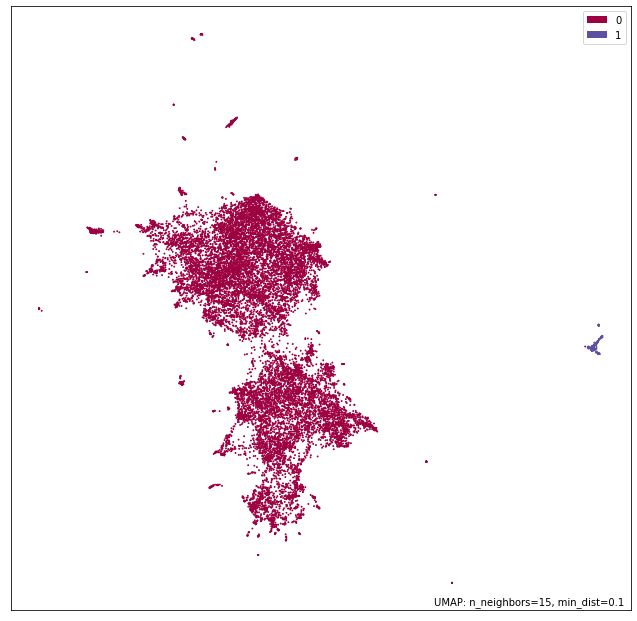

In [ ]:
umap.plot.points(mapper, labels=cluster_labels)

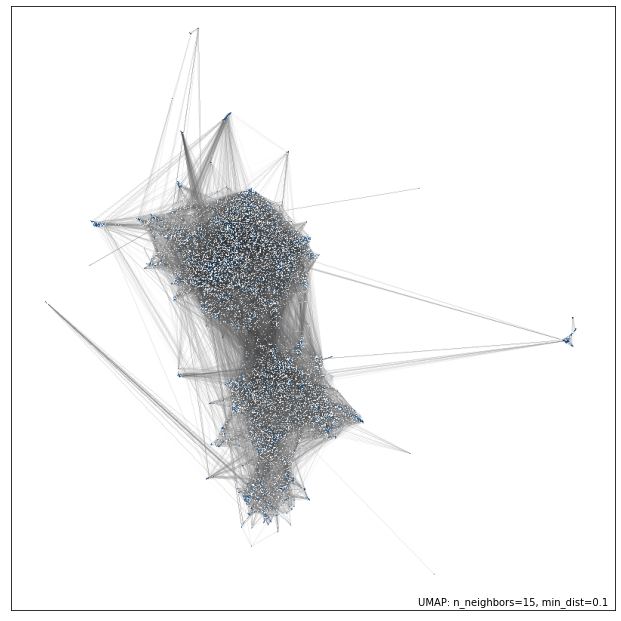

In [ ]:
umap.plot.connectivity(mapper, show_points=True)

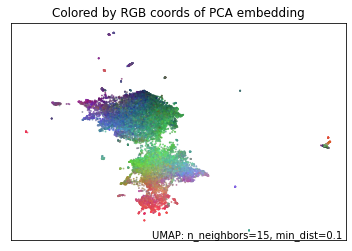

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

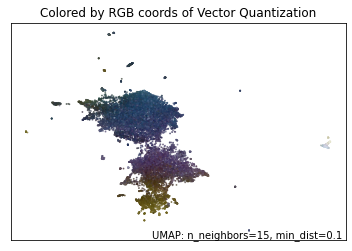

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

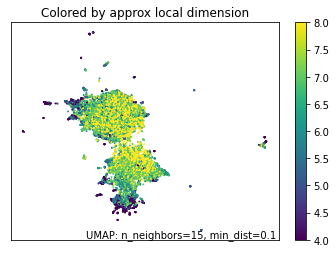

In [ ]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

/usr/local/lib/python3.7/dist-packages/umap/plot.py:203: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_nhood_compare" failed type inference due to: No implementation of function Function(<function hstack at 0x7f2be1096c20>) found for signature:
 
 >>> hstack(list(array(int32, 1d, C))<iv=None>)
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 129.
    With argument(s): '(list(array(int32, 1d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypeError: np.hstack(): expecting a non-empty tuple of arrays, got list(array(int32, 1d, C))<iv=None>
  raised from /usr/local/lib/python3.7/dist-packages/numba/core/typing/npydecl.py:749

During: resolving callee type: Function(<function hstack at 0x7f2be1096c20>)
During: typing of call at /usr/local/lib/python3.7/dist-packag

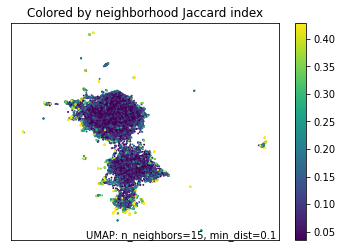

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

In [18]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=2)
cluster_labels = clustering.fit_predict(c_added)


In [19]:
final_res['concatenated_vector'] = c_added.tolist()

final_res.head()

,filename,review_vector,reviews_sentence,imgvector,concatenated_vector
0,B074FBNXNP,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.10169321, 0.1718068, -0.7686428, -0.307252...","[-0.23362812399864197, -0.3767344057559967, 0...."
1,B0059K9WK0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.048923768, 0.26097292, -0.36208984, -0.280...","[-0.23362812399864197, -0.3767344057559967, 0...."
2,B01GAJY4V0,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[0.060619622, 0.39073166, -0.52485764, -0.1011...","[-0.23362812399864197, -0.3767344057559967, 0...."
3,B01MSPJV0K,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[0.5096084, 0.2489464, -0.4452468, -0.02296139...","[-0.23362812399864197, -0.3767344057559967, 0...."
4,B071KCWVH5,"[-0.23362812, -0.3767344, 0.4676712, -0.243224...",good choice,"[-0.2386987, 0.0766793, -0.5877766, -0.152046,...","[-0.23362812399864197, -0.3767344057559967, 0...."


In [20]:
final_res_vec_file = final_res.drop(['review_vector','reviews_sentence','imgvector'], axis=1)

final_res_vec_file.head()

,filename,concatenated_vector
0,B074FBNXNP,"[-0.23362812399864197, -0.3767344057559967, 0...."
1,B0059K9WK0,"[-0.23362812399864197, -0.3767344057559967, 0...."
2,B01GAJY4V0,"[-0.23362812399864197, -0.3767344057559967, 0...."
3,B01MSPJV0K,"[-0.23362812399864197, -0.3767344057559967, 0...."
4,B071KCWVH5,"[-0.23362812399864197, -0.3767344057559967, 0...."


In [21]:
final_res_vec_file['cluster_labels'] = cluster_labels

In [ ]:
final_res_vec_file.head()

,filename,concatenated_vector,cluster_labels
0,B074FBNXNP,"[-0.23362812399864197, -0.3767344057559967, 0....",0
1,B0059K9WK0,"[-0.23362812399864197, -0.3767344057559967, 0....",0
2,B01GAJY4V0,"[-0.23362812399864197, -0.3767344057559967, 0....",0
3,B01MSPJV0K,"[-0.23362812399864197, -0.3767344057559967, 0....",0
4,B071KCWVH5,"[-0.23362812399864197, -0.3767344057559967, 0....",0


In [22]:
files = final_res_vec_file[final_res_vec_file['cluster_labels'] == 1]['filename']

In [ ]:
np.unique(cluster_labels)

array([0, 1])

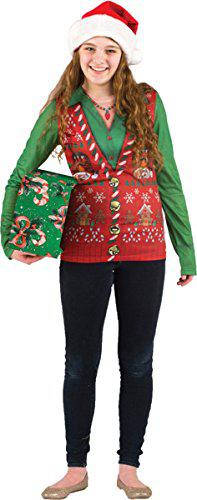

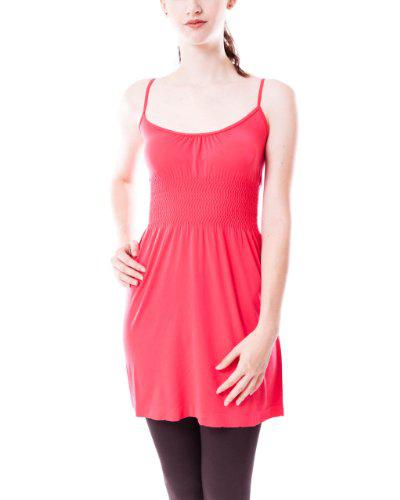

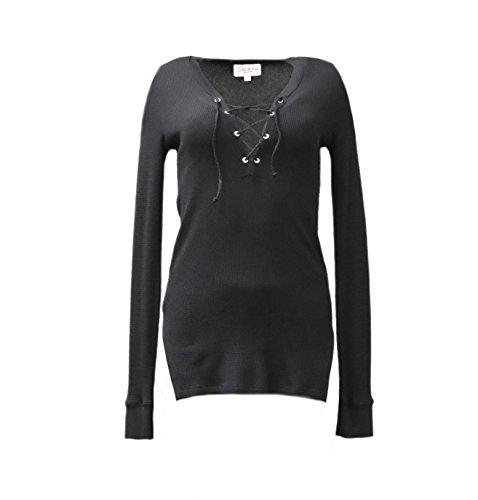

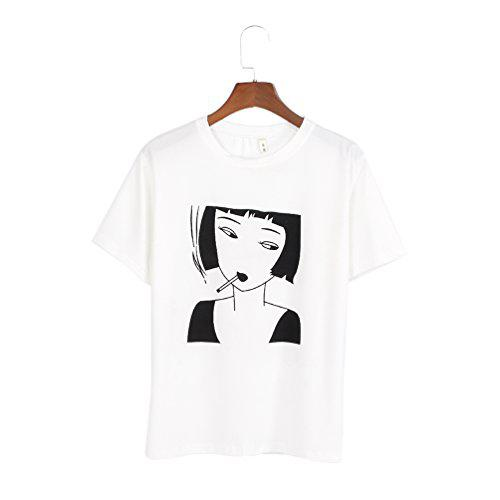

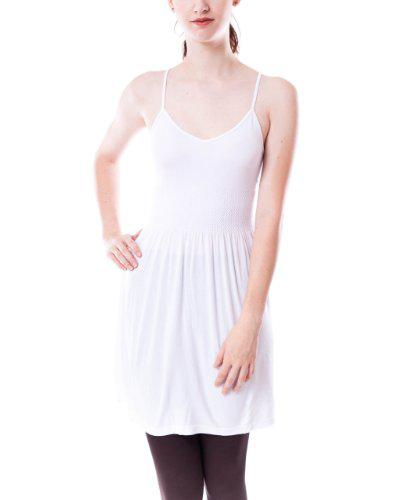

In [ ]:
from google.colab.patches import cv2_imshow
import cv2 as cv
for f_n in files[:5]:
  img = cv.imread(os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', f_n+'.jpeg' ), cv.IMREAD_COLOR)
 
  cv2_imshow(img)

In [24]:
with open('explore.pickle', 'wb') as f:
        pickle.dump(files, f)

In [23]:
!rm -r explore.pickle